In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import data_preprocessing.data_loading as dl
import data_preprocessing.data_preprocess as dp


In [2]:
x_var='Democracy'
y_var='Education Expansion'

In [ ]:
politicians = {"chrupalla": "AfD", "soeder": "CDU/CSU", "scholz": "SPD", "laschet": "CDU/CSU", "baerbock": "90/Greens", "weidel": "AfD", 
               "lindner": "FDP", "wissler": "LINKE", "bartsch": "LINKE"}
valence = dl.get_valence_from_gesis(politicians)

# aggregate for parties where there are multiple spitzenkandidaten
valence = valence.groupby("party", as_index=False).agg({"politician": ' '.join, "valence": "mean"})
valence

,party,politician,valence
0,90/Greens,baerbock,4.660272
1,AfD,weidel chrupalla,2.691033
2,CDU/CSU,laschet soeder,4.467879
3,FDP,lindner,5.323999
4,LINKE,bartsch wissler,3.237964
5,SPD,scholz,6.222786


In [4]:
party_scaled, voter_scaled = dp.get_scaled_party_voter_data(x_var=x_var, y_var=y_var)

c:\Users\denid\Desktop\Case_Study_TUM25\data_preprocessing\data_loading.py:40: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [5]:
def plot(voter_scaled, party_scaled):
    count = voter_scaled[[f"{x_var} Scaled", f"{y_var} Scaled"]].value_counts()
    z_voter = count.values
    x_voter = count.index.get_level_values(0).values
    y_voter = count.index.get_level_values(1).values

    x_party = party_scaled[x_var + " Voters_Mean"]
    y_party = party_scaled[y_var + " Voters_Mean"]

    plt.Figure()

    plt.scatter(x_voter, y_voter, z_voter)
    plt.scatter(x_party, y_party)
    plt.xlabel(x_var)
    plt.ylabel(y_var)

    if "Label" in party_scaled:
        label = party_scaled["Label"]
        for x, y, text in zip(x_party, y_party, label):
            plt.text(x, y, text)

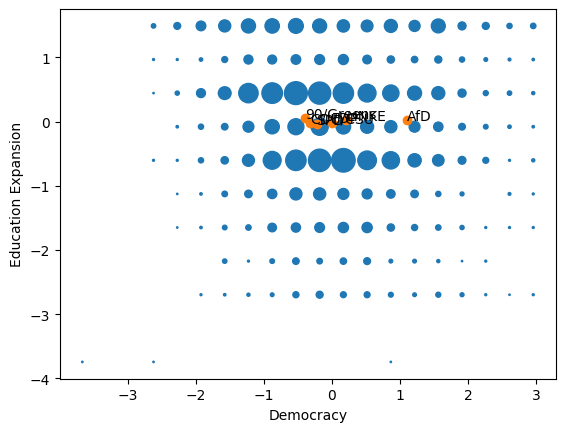

In [6]:
plot(voter_scaled, party_scaled)

In [7]:
party_scaled_df = party_scaled[['Country', 'Date', 'Calendar_Week', 'Party_Name', f'{x_var} Combined', f'{y_var} Combined', 'Label']].rename(
                              columns={f'{x_var} Combined': f'{x_var} Scaled', f'{y_var} Combined': f'{y_var} Scaled'})

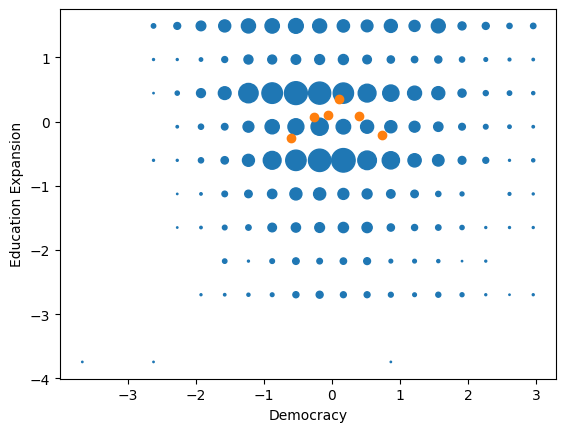

In [8]:
party_centered, voter_centered = dp.center_party_voter_data(voter_df=voter_scaled, party_df=party_scaled_df, x_var=x_var, y_var=y_var)

voter = voter_centered[[f'{x_var} Centered', f'{y_var} Centered']].copy()
party = party_centered[[f'{x_var} Centered', f'{y_var} Centered']].copy()

def plot(voter_scaled, party_scaled):
    count = voter_scaled[[f'{x_var} Centered', f'{y_var} Centered']].value_counts()
    z_voter = count.values
    x_voter = count.index.get_level_values(0).values
    y_voter = count.index.get_level_values(1).values

    x_party = party_scaled[f'{x_var} Centered']
    y_party = party_scaled[f'{y_var} Centered']

    plt.Figure()

    plt.scatter(x_voter, y_voter, z_voter)
    plt.scatter(x_party, y_party)
    plt.xlabel(x_var)
    plt.ylabel(y_var)

    if "Label" in party_scaled:
        label = party_scaled["Label"]
        for x, y, text in zip(x_party, y_party, label):
            plt.text(x, y, text)

plot(voter, party)

In [9]:
# covariance matrix calculation
xi_1 = voter[f'{x_var} Centered'].values
xi_2 = voter[f'{y_var} Centered'].values

covariance_matrix = np.zeros((2,2))
covariance_matrix[0,0] = np.dot(xi_1, xi_1)
covariance_matrix[1,1] = np.dot(xi_2, xi_2)
covariance_matrix[0,1] =  covariance_matrix[1,0] = np.dot(xi_1, xi_2)
covariance_matrix *= 1 / len(xi_1)
covariance_matrix

array([[ 1.        , -0.05368378],
       [-0.05368378,  1.        ]])

In [10]:
# v^2 calculation
v_sqr = np.trace(covariance_matrix)
v_sqr

2.0000000000000044

In [11]:
# \rho_1 calculation
min = valence["valence"].idxmin()
val = valence["valence"] - valence.loc[min, "valence"]
val = val[val.index.difference([min])]
val = np.exp(val)
rho_1 = 1 / (1 + val.sum())
rho_1

0.0156486754951062

In [12]:
# beta calculation
beta = 1
beta

1

In [13]:
# A_1 calculation
A_1 = beta * (1-2*rho_1)
A_1

0.9687026490097876

In [14]:
# characteristic matrix C_1
C_1 = 2 * A_1 * covariance_matrix - np.eye(covariance_matrix.shape[0])
C_1

array([[ 0.9374053 , -0.10400724],
       [-0.10400724,  0.9374053 ]])

In [15]:
np.linalg.eig(C_1)

EigResult(eigenvalues=array([1.04141254, 0.83339806]), eigenvectors=array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]]))

Text(0, 0, 'hallo')

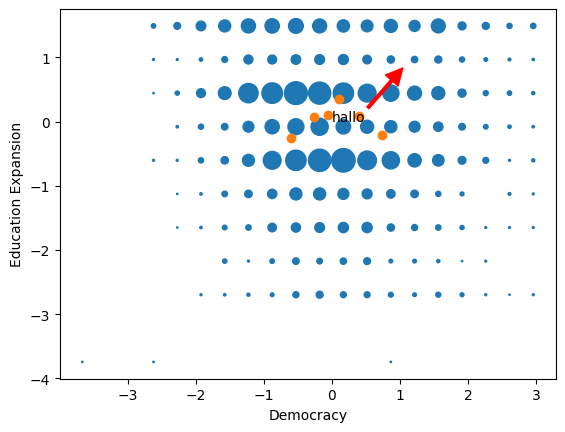

In [16]:
# plot positive eigenvector
plot(voter, party)
plt.annotate("hallo", (1.04141254, 0.83339806), (0,0), arrowprops=dict(width=2, color="red"))

In [17]:
# convergence coefficient calculation
convergence_coefficient = 2*A_1*v_sqr
convergence_coefficient

3.874810596039159